In [1]:
!pip install scikit-image
!pip install opencv-python

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import morphology, io
from skimage.transform import rescale, resize, downscale_local_mean

import os

from skimage.segmentation import slic, mark_boundaries
from skimage import feature #for feature extraction

import cv2

import math
from skimage import transform

In [3]:
#im = plt.imread('../data/raw/example_image/ISIC_0003462.jpg')
#mask=plt.imread('../data/raw/example_segmentation/ISIC_0003462_segmentation.png')

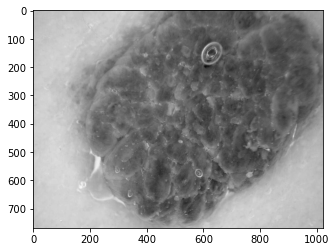

In [4]:
images = os.listdir('../data/interim/resized_images')
segments = os.listdir('../data/interim/resized_segments')
#Greyscaling
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

fim = plt.imread('../data/interim/resized_images/'+images[24])
fim_segment = plt.imread('../data/interim/resized_segments/'+segments[24])
gray = rgb2gray(fim)
plt.imshow(gray,cmap='gray')

68.0267333984375 %


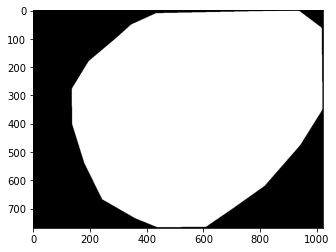

In [5]:
#Total size of the image
total = fim_segment.shape[0] * fim_segment.shape[1] 

#Size of mask only
area = np.sum(fim_segment)

#As percentage
print(area/total*100, "%")

plt.imshow(fim_segment, cmap='gray')

534984.0
530112


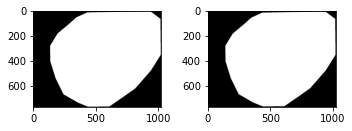

In [6]:
# Altea got the perimeter <3 <3
#Structural element, that we will use as a "brush" on our mask. The parameter is "brush size"
struct_el = morphology.disk(2)

#print(struct_el)

# Use this "brush" to erode the image - eat away at the borders

mask_eroded = morphology.binary_erosion(fim_segment, struct_el)

# Show side by side (depending on brush size, you might not see a difference visually)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(fim_segment, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify the new mask is smaller
new_area= np.sum(mask_eroded)

print(area)
print(new_area)

4872.0


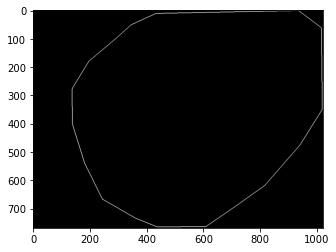

In [7]:
# Subtract the two masks from each other to get the border/perimeter

image_perimeter = fim_segment - mask_eroded

plt.imshow(image_perimeter, cmap='gray') #Depending on the size of the "brush" it might be difficult to see on the screen

#What is the length of this perimeter = how many 1s? 
print(np.sum(image_perimeter))
perimeter = np.sum(image_perimeter)

In [8]:
## we can make a zoomed in version using the mask later if this code is too complicated (also, plagarism?)

#https://stackoverflow.com/questions/59191179/finding-coordinates-of-corners-of-the-maskrectengular-shape-from-mask-matrixb

array = fim_segment
H,W = array.shape

left_edges = np.where(array.any(axis=1),array.argmax(axis=1),W+1)
flip_lr = cv2.flip(array,1) #1 horz vert 0
right_edges = W - np.where(flip_lr.any(axis=1),flip_lr.argmax(axis=1),W+1)
top_edges = np.where(array.any(axis=0),array.argmax(axis=0),H+1)
flip_ud = cv2.flip(array,0) #1 horz vert 0
bottom_edges = H - np.where(flip_ud.any(axis=0),flip_ud.argmax(axis=0),H+1)

leftmost = left_edges.min()
rightmost = right_edges.max()
topmost = top_edges.min()
bottommost = bottom_edges.max()

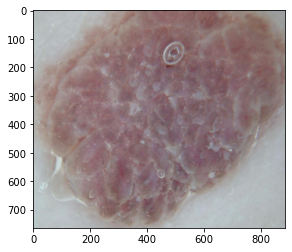

In [9]:
im2 = fim[topmost:bottommost,leftmost:rightmost,:]
mask2 = fim_segment[topmost:bottommost,leftmost:rightmost]
plt.imshow(im2)

In [10]:
# store features in a vector
# {x_A, x_B, x_C} --> x_A is Asymmetry, x_B is Border, x_C is Color --> let x_C be a set of x_R, x_G, x_B

147879.5


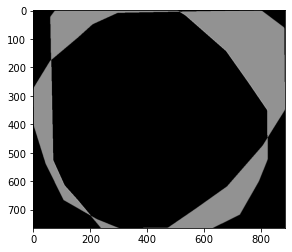

In [22]:
### Asymmetry
## if rotated lesion and lesion are overlapped and there exists a high value of gray, then the lesion is assymetric

rot_fim = transform.rotate(mask2, 90)
new_im = rot_fim+mask2
new_im[new_im == 2] = 0
plt.imshow(new_im, cmap='gray')
print(np.sum(new_im))

# number of grey pixels depends on the size of the lesion as well
# so even if the lesion is small, it would still have a lot of gray pixels

In [12]:
### Measuring shape with area and perimeter
## Compactness = l^2/(4pi*A) --> l = perimeter, A = area

c = (perimeter)**2/(4*math.pi*area)
print(c)

## the minimal the value of c (aka the close it is to 1), the more symmetric (circular) it is
# cannot be 1 perfectly due to pixels

# how is compactness different from symmetry
## why check assymetry? a hexagon is pretty symmetrical

3.5307250728315003


In [17]:
### Measuring "average" color

# average luminance --> ?
# grayscale image and calculate average --> but what does this tell us? how is this feature valuable?

#calculating color features
colors_of_lesion = im2[mask2==1]
x_R, x_G, x_B = np.mean(colors_of_lesion, axis = 0)
print(x_R, x_G, x_B)

avg_color = (x_R + x_G + x_B)/3
print(avg_color)

142.95649028756 119.7736586514737 121.06322058229779
127.93112317377717
